In [ ]:
# Team :
#   The Lost Boy: The Hull moving average and the Directional Moving Index (ADX)

# API Key = GPOTJ4638HWF4A6H

In [1]:
# Milestone 1 – Data Acquisition & Preparation (Weeks 1-4)
# Daily Pull Test

import requests

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&interval=5min&apikey=GPOTJ4638HWF4A6H'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2025-09-29', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-09-29': {'1. open': '286.0000', '2. high': '286.0000', '3. low': '279.6600', '4. close': '279.8000', '5. volume': '5923526'}, '2025-09-26': {'1. open': '280.5100', '2. high': '288.8500', '3. low': '280.1100', '4. close': '284.3100', '5. volume': '9063938'}, '2025-09-25': {'1. open': '272.9350', '2. high': '284.2300', '3. low': '271.1480', '4. close': '281.4400', '5. volume': '11506192'}, '2025-09-24': {'1. open': '272.6200', '2. high': '273.6499', '3. low': '267.3000', '4. close': '267.5300', '5. volume': '3159924'}, '2025-09-23': {'1. open': '272.7000', '2. high': '273.2962', '3. low': '269.2650', '4. close': '272.2400', '5. volume': '5394121'}, '2025-09-22': {'1. open': '266.6200', '2. high': '272.3100', '3. low': '266.0000', '4. close': '271.3700', '5. vol

In [2]:
# Pulling using ADX (Average Daily Index)
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=GPOTJ4638HWF4A6H'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2025-09-29', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-09-29': {'1. open': '286.0000', '2. high': '286.0000', '3. low': '279.6600', '4. close': '279.8000', '5. volume': '5923526'}, '2025-09-26': {'1. open': '280.5100', '2. high': '288.8500', '3. low': '280.1100', '4. close': '284.3100', '5. volume': '9063938'}, '2025-09-25': {'1. open': '272.9350', '2. high': '284.2300', '3. low': '271.1480', '4. close': '281.4400', '5. volume': '11506192'}, '2025-09-24': {'1. open': '272.6200', '2. high': '273.6499', '3. low': '267.3000', '4. close': '267.5300', '5. volume': '3159924'}, '2025-09-23': {'1. open': '272.7000', '2. high': '273.2962', '3. low': '269.2650', '4. close': '272.2400', '5. volume': '5394121'}, '2025-09-22': {'1. open': '266.6200', '2. high': '272.3100', '3. low': '266.0000', '4. close': '271.3700', '5. vol

In [3]:
# Setup for Project

import os, json
from datetime import datetime
from pathlib import Path

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 5)
pd.set_option('display.max_columns', 50)

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

API_KEY = "GPOTJ4638HWF4A6H"

In [ ]:
# Data Extracting

# Register for an API key with Alpha Vantage.
# Extract time series stock data using Python.
# Perform exploratory visualizations (line plots, rolling statistics, summary statistics).
# Submit: A Jupyter notebook documenting the extraction process and initial exploration.

In [4]:
# STEP 1 — Extract time series stock data from Alpha Vantage (free JSON)

import os, time, requests
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)

# 1) Set your key here or via env var
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "GPOTJ4638HWF4A6H")
BASE_URL = "https://www.alphavantage.co/query"

def _fetch_json(params, retries=3, sleep_s=15):
    for i in range(retries):
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        payload = r.json()
        # If it looks like data, return; if it's a note/info, backoff and retry
        if isinstance(payload, dict) and any("Time Series" in k for k in payload.keys()):
            return payload
        # If rate limit ("Note"), back off and try again
        if isinstance(payload, dict) and "Note" in payload and i < retries - 1:
            time.sleep(sleep_s)
            continue
        # Otherwise, stop here and let caller diagnose
        return payload
    return payload

def fetch_time_series(symbol: str, use_adjusted: bool = True, outputsize: str = "compact") -> pd.DataFrame:
    """
    Try Daily Adjusted first (free JSON). If missing, fallback to Daily (free JSON).
    Returns a tidy DataFrame indexed by datetime with numeric columns.
    """
    functions = ["TIME_SERIES_DAILY_ADJUSTED", "TIME_SERIES_DAILY"] if use_adjusted else ["TIME_SERIES_DAILY"]
    last_payload = None
    for fn in functions:
        params = {"function": fn, "symbol": symbol, "outputsize": outputsize, "apikey": API_KEY}
        payload = _fetch_json(params)
        last_payload = payload
        key = next((k for k in payload.keys() if "Time Series" in k), None) if isinstance(payload, dict) else None
        if key:
            ts = payload[key]
            df = pd.DataFrame(ts).T.rename_axis("timestamp")
            df.index = pd.to_datetime(df.index)
            df = df.rename(columns=lambda c: c.split(". ", 1)[-1])  # "1. open" -> "open"
            df = df.apply(pd.to_numeric, errors="coerce").sort_index()
            return df
        # if this attempt failed, try next function (or diagnose after loop)
    # If we got here, nothing worked; print payload details to help you see the cause
    print("DEBUG — Raw payload (truncated):")
    try:
        import json
        print(json.dumps(last_payload, indent=2)[:1200])
    except Exception:
        print(Exception)

# Restore your key and fetch your chosen symbol
symbol = "IBM"          # change if you like, e.g., "AAPL", "MSFT"
outputsize = "compact"  # "full" is allowed but larger (and slower)

print(f"\nFetching {symbol} with your key...")
df = fetch_time_series(symbol, use_adjusted=True, outputsize=outputsize)

# Save and show a peek
out_path = DATA_DIR / f"{symbol}_daily.csv"
df.to_csv(out_path)
print(f"✅ Downloaded {symbol}: {len(df)} rows → {out_path}")
print(f"Date range: {df.index.min().date()} → {df.index.max().date()}")
df.head()


Fetching IBM with your key...
✅ Downloaded IBM: 100 rows → data/IBM_daily.csv
Date range: 2025-05-07 → 2025-09-29


,open,high,low,close,volume
timestamp,,,,,
2025-05-07,249.45,254.47,248.832,253.37,3400001
2025-05-08,255.00,256.52,253.250,254.14,3637012
2025-05-09,252.51,253.00,247.640,249.20,2901346
2025-05-12,252.50,253.81,244.650,253.69,4609520
2025-05-13,254.43,259.58,252.880,258.59,3521389


=== Summary statistics ===
          open     high      low    close        volume
count  100.000  100.000  100.000  100.000  1.000000e+02
mean   264.495  266.970  262.044  264.828  4.558109e+06
std     16.942   17.153   16.986   17.013  2.659338e+06
min    236.200  237.960  233.360  234.770  1.853289e+06
25%    251.882  254.192  248.652  252.205  3.154086e+06
50%    261.125  264.500  259.255  262.810  3.661166e+06
75%    281.237  284.174  279.840  281.852  4.998951e+06
max    294.550  296.160  290.361  294.780  2.264772e+07


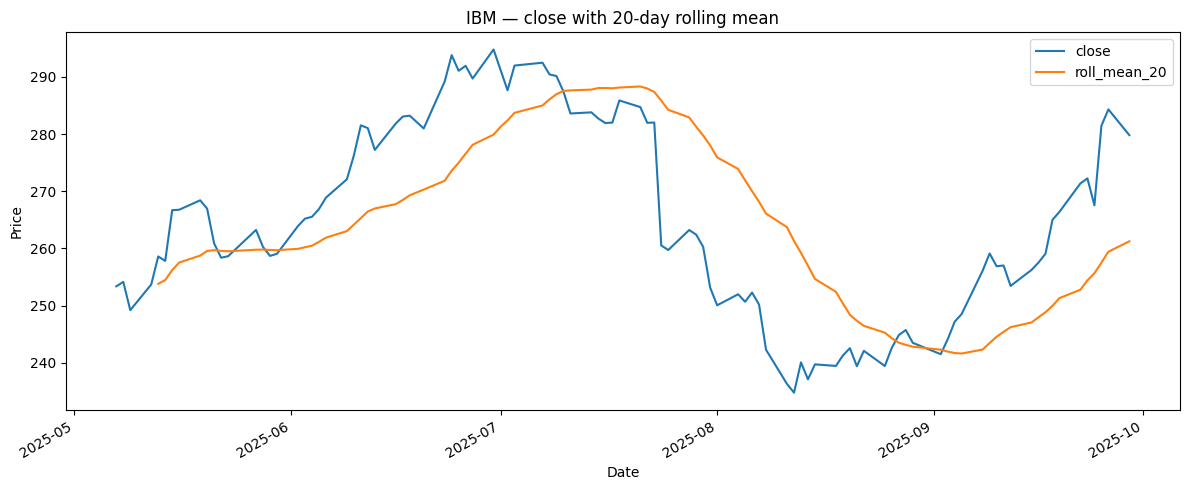

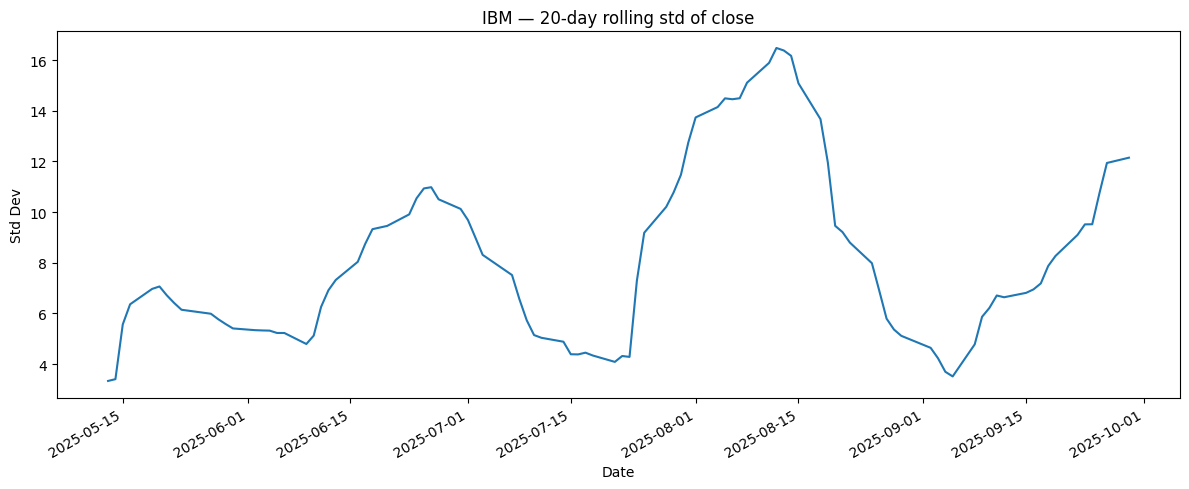

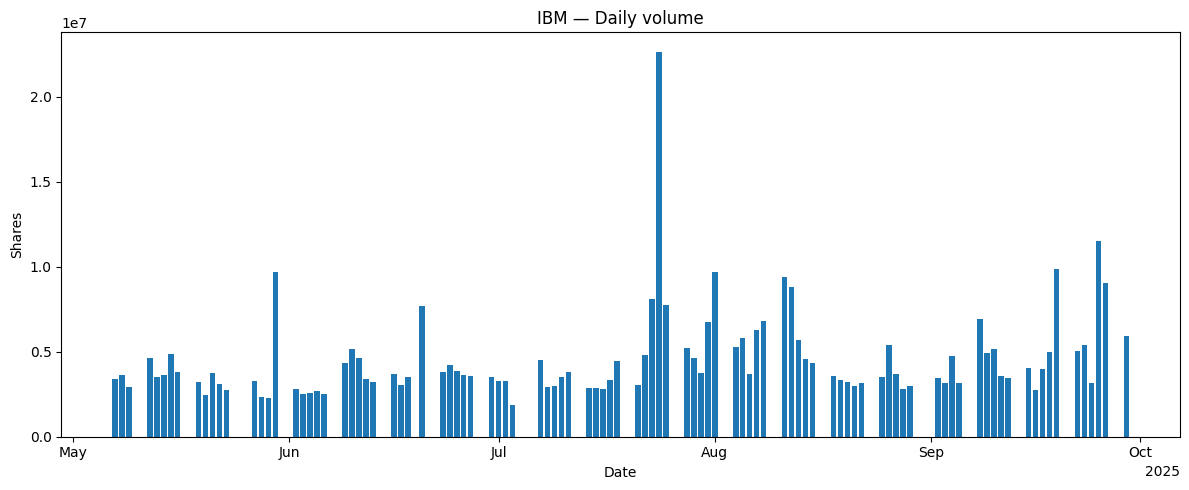

In [5]:
# STEP 2 — Exploratory visuals (line plot, rolling stats) + summary stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data")
symbol = "IBM"  # keep in sync with Step 1
csv_path = DATA_DIR / f"{symbol}_daily.csv"

# Load from disk so we don't re-hit the API
df = pd.read_csv(csv_path, parse_dates=["timestamp"]).set_index("timestamp").sort_index()

# Choose a price column that exists (some responses have 'adjusted_close', some just 'close')
price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"

# Rolling stats (20-day)
df["roll_mean_20"] = df[price_col].rolling(20, min_periods=5).mean()
df["roll_std_20"]  = df[price_col].rolling(20, min_periods=5).std()

# Simple returns (optional, nice for EDA)
df["return_1d"] = df[price_col].pct_change()

# ----- Summary stats (table) -----
summary = df[["open","high","low",price_col,"volume"]].describe().round(3)
print("=== Summary statistics ===")
print(summary)

# Save summary to disk
summary.to_csv(DATA_DIR / f"{symbol}_summary_stats.csv")

# ----- Plots -----
# 1) Price with rolling mean
plt.figure()
df[price_col].plot(label=price_col)
df["roll_mean_20"].plot(label="roll_mean_20")
plt.title(f"{symbol} — {price_col} with 20-day rolling mean")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# 2) Rolling volatility proxy (std dev)
plt.figure()
df["roll_std_20"].plot()
plt.title(f"{symbol} — 20-day rolling std of {price_col}")
plt.xlabel("Date")
plt.ylabel("Std Dev")
plt.tight_layout()
plt.show()

# 3) Volume (last ~100 days from compact), with date-aware axis
plt.figure()
ax = plt.gca()
ax.bar(df.index, df["volume"])
ax.set_title(f"{symbol} — Daily volume")
ax.set_xlabel("Date")
ax.set_ylabel("Shares")
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
plt.tight_layout()
plt.show()

In [6]:
# Identifying Time Series Components

# Decompose the series into trend, seasonality, and residuals.
# Perform ACF and PACF analysis.
# Run stationarity tests (ADF).
# Report with plots and interpretations of time series characteristics.

=== TIME SERIES CHARACTERISTICS REPORT ===



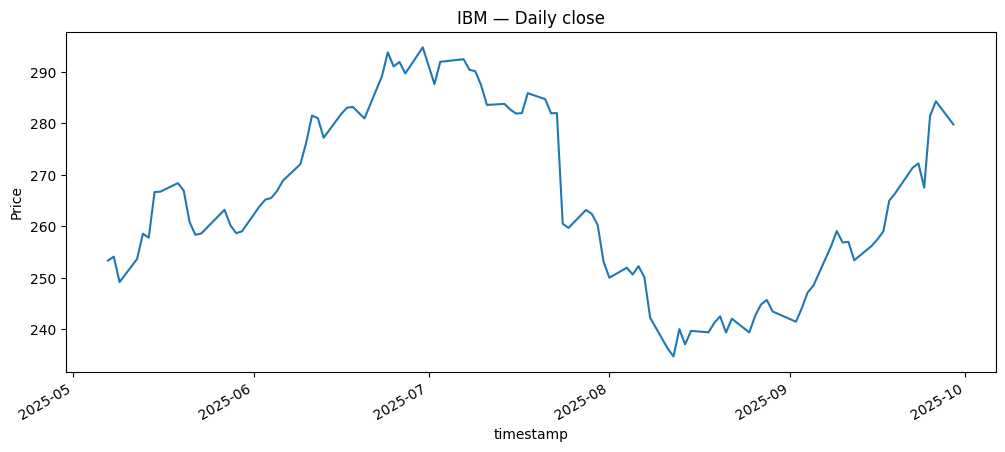

The raw price series shows an upward/downward drift and volatility clustering, suggesting it is likely non-stationary.


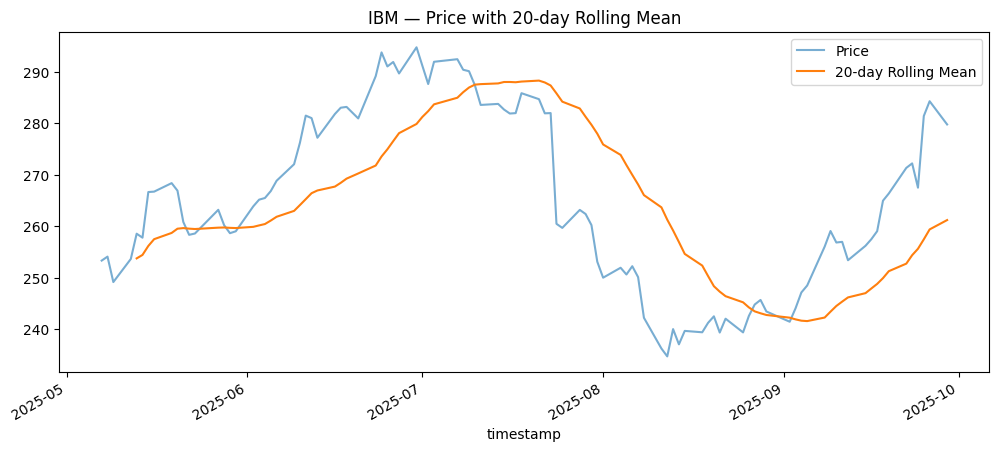

Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.


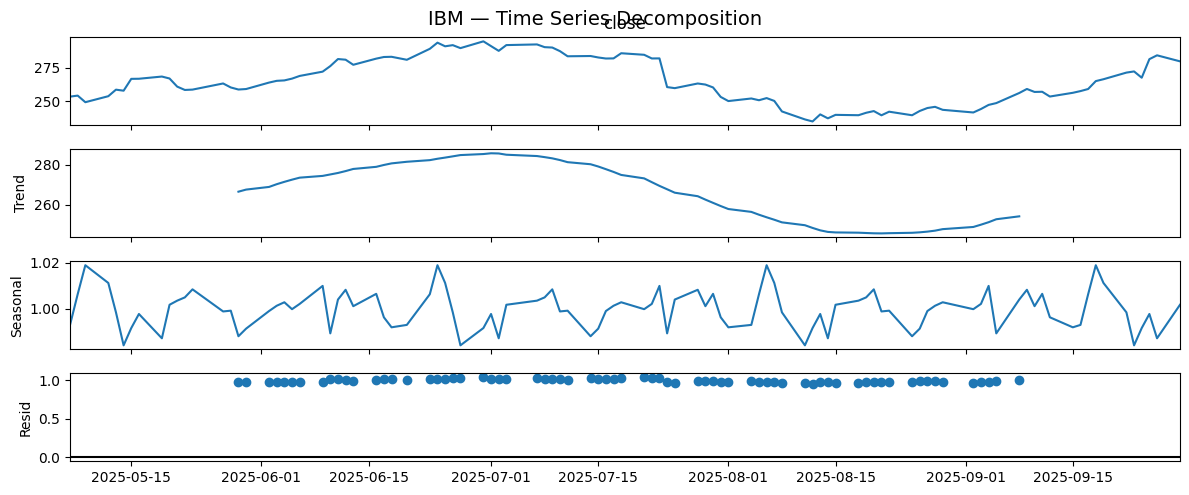

Decomposition separates the series into:
- Trend: Long-term direction of the stock price.
- Seasonality: Repeating short-term cycles (monthly/weekly effects).
- Residuals: Irregular noise not explained by trend or seasonality.



<Figure size 1000x400 with 0 Axes>

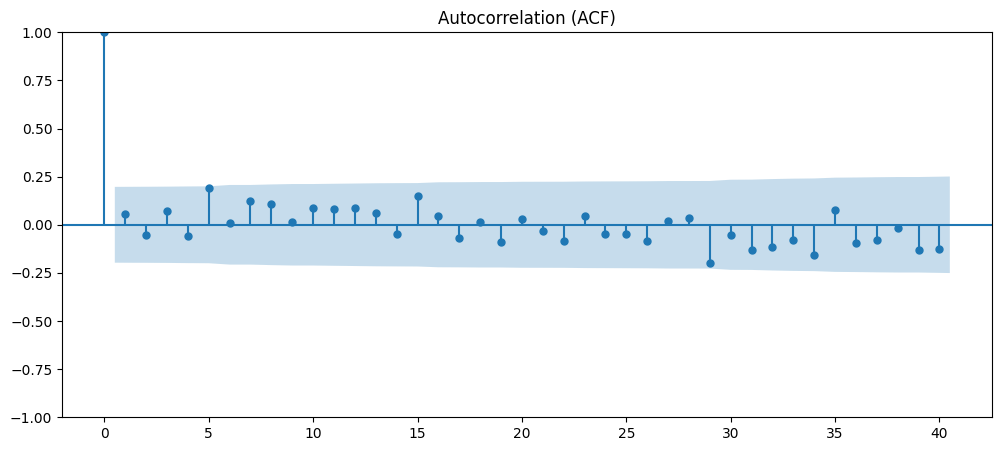

<Figure size 1000x400 with 0 Axes>

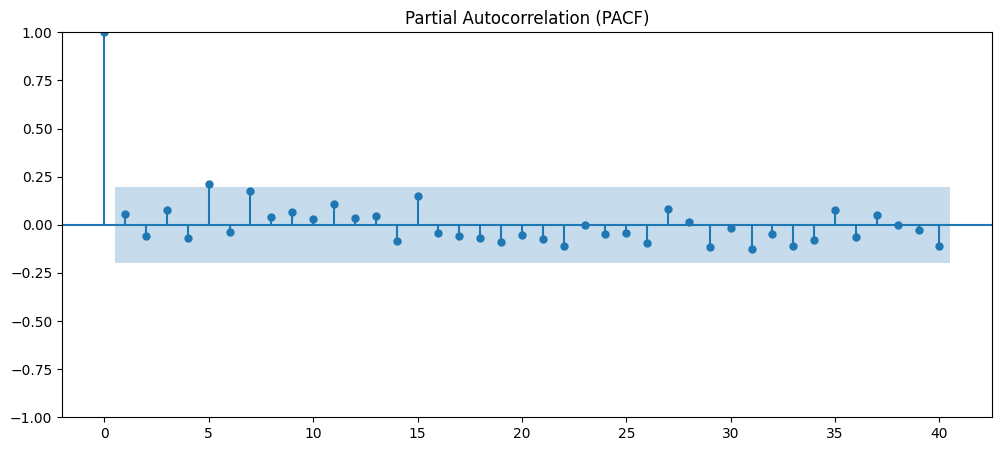

ACF shows correlations with past lags; PACF isolates direct effects of lags. These help identify ARIMA model orders.

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -9.2107
p-value      : 0.0000
Critical Values: {'1%': np.float64(-3.4989097606014496), '5%': np.float64(-2.891516256916761), '10%': np.float64(-2.5827604414827157)}
✅ The series is stationary (reject null hypothesis).


In [7]:
import matplotlib.pyplot as plt

print("=== TIME SERIES CHARACTERISTICS REPORT ===\n")

# 1) Plot the raw series
plt.figure(figsize=(12, 5))
df[price_col].plot(title=f"{symbol} — Daily {price_col}")
plt.ylabel("Price")
plt.show()
print("The raw price series shows an upward/downward drift and volatility clustering, "
      "suggesting it is likely non-stationary.")

# 2) Plot rolling stats
plt.figure(figsize=(12, 5))
df[price_col].plot(label="Price", alpha=0.6)
df["roll_mean_20"].plot(label="20-day Rolling Mean")
plt.title(f"{symbol} — Price with 20-day Rolling Mean")
plt.legend()
plt.show()
print("Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.")

# 3) Decomposition (Trend/Seasonality/Residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[price_col].dropna(), model="multiplicative", period=30)
result.plot()
plt.suptitle(f"{symbol} — Time Series Decomposition", fontsize=14)
plt.show()
print("Decomposition separates the series into:\n"
      "- Trend: Long-term direction of the stock price.\n"
      "- Seasonality: Repeating short-term cycles (monthly/weekly effects).\n"
      "- Residuals: Irregular noise not explained by trend or seasonality.\n")

# 4) ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df['return_1d'].dropna(), lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df['return_1d'].dropna(), lags=40, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()
print("ACF shows correlations with past lags; PACF isolates direct effects of lags. "
      "These help identify ARIMA model orders.")

# 5) ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['return_1d'].dropna(), autolag='AIC')
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✅ The series is stationary (reject null hypothesis).")
else:
    print("❌ The series is non-stationary (fail to reject null). Differencing needed.")

In [8]:
# Dealing with Non-Stationarity & Modeling

# Apply differencing, transformations, or detrending as needed.
# Implement and compare MA, AR, and ARIMA models.
# Evaluate model accuracy (e.g., AIC, BIC, RMSE).
# Provide consulting-style recommendations to your client.

In [9]:
# Apply Differencing / Transformations

import numpy as np

# Log-transform (helps stabilize variance)
df["log_price"] = np.log(df[price_col])

# First difference of log price (approx daily returns)
df["diff_log_price"] = df["log_price"].diff()

# Drop NaNs
stationary_series = df["diff_log_price"].dropna()

# Re-run ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(stationary_series, autolag="AIC")

print("=== ADF on Differenced Log Price ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")

=== ADF on Differenced Log Price ===
ADF Statistic: -9.1996
p-value      : 0.0000


In [10]:
# AR, MA, ARIMA Models

from statsmodels.tsa.arima.model import ARIMA

results = {}

# AR(1) model
model_ar = ARIMA(stationary_series, order=(1,0,0))
fit_ar = model_ar.fit()
results["AR(1)"] = fit_ar

# MA(1) model
model_ma = ARIMA(stationary_series, order=(0,0,1))
fit_ma = model_ma.fit()
results["MA(1)"] = fit_ma

# ARIMA(1,1,1) model (includes differencing)
model_arima = ARIMA(df[price_col], order=(1,1,1))
fit_arima = model_arima.fit()
results["ARIMA(1,1,1)"] = fit_arima

# Compare summary outputs
for name, model in results.items():
    print(f"\n=== {name} ===")
    print(model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== AR(1) ===
                               SARIMAX Results                                
Dep. Variable:         diff_log_price   No. Observations:                   99
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 270.340
Date:                Tue, 30 Sep 2025   AIC                           -534.679
Time:                        01:53:54   BIC                           -526.894
Sample:                             0   HQIC                          -531.530
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.517      0.605      -0.003       0.005
ar.L1          0.0571      0.149      0.383      0.702      -0.235       0.349
sigma2         0.0002   1.92e-05     

In [11]:
# Evaluate Model Accuracy (fixed: align lengths)

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

eval_rows = []

for name, model in results.items():
    aic = model.aic
    bic = model.bic

    # fitted values as a Pandas Series
    fitted = pd.Series(model.fittedvalues)

    # target (endogenous) series used by THIS model, with same index as fitted
    # (works across AR/MA on stationary_series and ARIMA on levels)
    try:
        endog = pd.Series(model.model.endog, index=fitted.index)
    except Exception:
        # Fallback: reindex your stationary series to fitted's index
        endog = pd.Series(stationary_series).reindex(fitted.index)

    # align & drop NaNs to ensure equal length
    aligned = pd.concat([endog.rename("y_true"), fitted.rename("y_hat")], axis=1).dropna()

    rmse = np.sqrt(mean_squared_error(aligned["y_true"], aligned["y_hat"]))
    n_used = len(aligned)

    eval_rows.append((name, aic, bic, rmse, n_used))

eval_df = pd.DataFrame(eval_rows, columns=["Model", "AIC", "BIC", "RMSE (in-sample)", "N used"])
print("=== Model Comparison (aligned) ===")
print(eval_df.sort_values(["AIC"]))

=== Model Comparison (aligned) ===
          Model         AIC         BIC  RMSE (in-sample)  N used
1         MA(1) -534.695697 -526.910337          0.015768      99
0         AR(1) -534.679494 -526.894135          0.015770      99
2  ARIMA(1,1,1)  565.194225  572.979584        265.235843      99
